In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Magnetization

In [2]:
dfs = []
for file in os.listdir("summary"):
    fullpath = os.path.join("summary", file)
    with open(fullpath, "r") as f:
        lines = f.readlines()
        if len(lines) == 0:
            continue

        data = lines[0].split(sep=" ")
        if len(data) % 2 != 0:
            continue

        columns = data[::2]
        values = data[1::2]
        data = {column: [float(value)] for column,value in zip(columns, values)}

        for row in lines[1:]:
            row = row.split(sep=" ")
            columns = row[::2]
            values = row[1::2]
            for column, value in zip(columns, values):
                data[column].append(float(value))

        dfs.append(pd.DataFrame.from_dict(data))

df = pd.concat(dfs)

Text(0, 0.5, 'm')

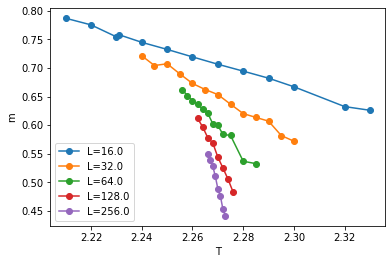

In [3]:
# m vs T
fig, ax = plt.subplots(1,1)
for df in dfs:
    m = df["m"]
    L = df["L"].iloc[0]
    T = df["T"]

    ax.plot(T, m, '-o', label=f"L={L}")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("m")

Text(0, 0.5, '$mL^{\\beta/v}$')

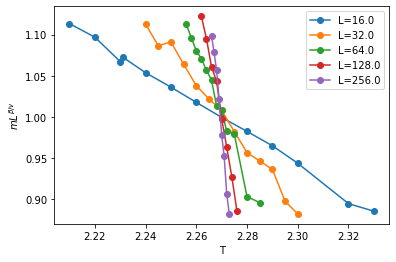

In [4]:
# mL^{beta/v} vs T
beta = 1.0/8.0
v = 1
fig, ax = plt.subplots(1,1)
for df in dfs:
    m = df["m"]
    L = df["L"]
    T = df["T"]

    ax.plot(T, m*np.power(L, beta/v), '-o', label=f"L={L.iloc[0]}")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel(r"$mL^{\beta/v}$")

C:\Users\bajs1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bajs1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\bajs1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\bajs1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bajs1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduc

(-0.25, 0.25)

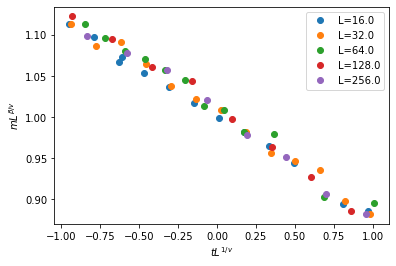

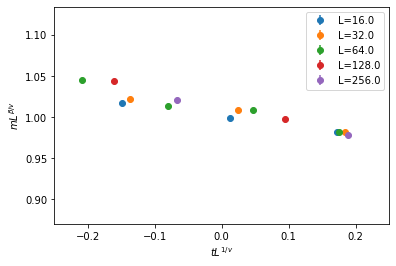

In [5]:
# mL^beta/v vs tL^1/v
Tc = 2.26926
fig, ax = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)
for df in dfs:
    m = df["m"]
    m_var = df["m_variance"]
    L = df["L"]
    T = df["T"]

    t = T - Tc

    L_beta_v = np.power(L, beta/v)
    y_err = np.sqrt(m_var*L_beta_v*L_beta_v)

    xval = t*np.power(L, 1.0/v)
    yval = m*np.power(L, beta/v)
    ax.plot(xval, yval, 'o', label=f"L={L.iloc[0]}")
    ax2.errorbar(xval, yval, yerr=y_err, label=f"L={L.iloc[0]}", marker='o', linestyle='')
ax.legend()
ax.set_xlabel("$tL^{1/v}$")
ax.set_ylabel(r"$mL^{\beta/v}$")
ax2.set_xlabel("$tL^{1/v}$")
ax2.set_ylabel(r"$mL^{\beta/v}$")
ax2.legend()

ax2.set_xlim([-0.25, 0.25])

# Binder's Cumulant

Text(0, 0.5, 'Q')

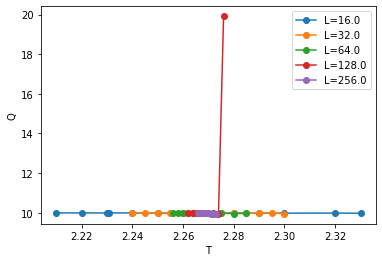

In [6]:
# Q vs T
fig, ax = plt.subplots(1,1)
for df in dfs:
    if df["L"].iloc[0] == 128:
        continue
    Q = df["Q"]
    L = df["L"]
    T = df["T"]

    ax.plot(T, Q, '-o', label=f"L={L.iloc[0]}")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("Q")

Text(0, 0.5, 'Q')

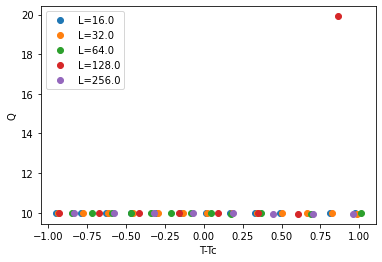

In [7]:
# Q vs tL^{1/v}
fig, ax = plt.subplots(1,1)
for df in dfs:
    Q = df["Q"]
    L = df["L"]
    T = df["T"]
    t = T-Tc

    xvals = t*np.power(L, 1.0/v)

    ax.plot(xvals, Q, 'o', label=f"L={L.iloc[0]}")
ax.legend()
ax.set_xlabel("T-Tc")
ax.set_ylabel("Q")